# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *D*

**Names:**

* Lejal Glaude Emma
* Bickel Marc
* Cadoux Cyril

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [1]:
# Basic libs
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### First we write a function that reads a .graph file and extracts a graph from it :

In [2]:
# Important : Here we parse the nodes from string (file reading) to int  => easier manipulations 

def read_g (location):
    
    # We use directed graphs here
    G = nx.DiGraph()

    file = open(location, 'r')


    for line in file:

        #Split the file's line into 'words'
        nodes = line.split()

        #The first word is the starting node
        G.add_node(int(nodes[0]))

        #Only if the starting point is explicitely linked with other nodes
        if (len(nodes) > 1):
            for i in range (1, len(nodes)):

                #The following words are the end points
                G.add_edge(int(nodes[0]), int(nodes[i]))  

    file.close()
    
    return G

##### We also define 2 basics functions :

In [3]:
'''The restart function just returns a uniformly chosen node from the graph'''

def restart(G):
    return np.random.choice(G.nodes())


'''The announce function just prints the results '''

def announce (result):
    for i in range (len(result)):
        print("Node ", i, " has a score of ", result[i])

##### We can now define the function that exectutes the random surf on a graph with a certain number of iterations. 

In [4]:
'''Our implementation takes a graph G,
    a number of iterations default=100,
    the version (False(default)/True)
    and a boolean to enable the result printing
    in arguments.
    '''
    

def random_surf(G, iterations=100, enhanced=False, ok_print=True):
    
    result = np.zeros(G.order())
    damping = 0.15
    
    # The first node chosen at random
    actual_node = restart(G)
    
    for i in range (iterations):
        
        # Increase the score by 1
        result[actual_node] += 1
        
        # In enhanced version, apply the random restart
        if(enhanced and np.random.uniform() < damping):
            actual_node = restart(G)
        
        else :            
        
            nei = G.neighbors(actual_node)
            dangling = (len(nei) == 0)

            if(dangling and enhanced):            
                actual_node = restart(G)
                
            elif (not(dangling)):
                actual_node = np.random.choice(nei)
            
            # Else we are on a dangling node, with the naive version => do nothing (see below)
    
    
    if (ok_print):
        announce(result)
        
        
    return result       

##### Now we can apply our functions

First We create Ga and Gc from file :

In [5]:
Ga = read_g('../data/absorbing.graph')
Gc = read_g('../data/components.graph')

In [6]:
random_surf(Ga)

Node  0  has a score of  1.0
Node  1  has a score of  99.0
Node  2  has a score of  0.0
Node  3  has a score of  0.0
Node  4  has a score of  0.0


array([  1.,  99.,   0.,   0.,   0.])

By running the above cell several times, we see that node 1 has in average a very large score. This indicates that this is a dangling node. Indeed, if we ask the length of the neighbors list of node 1, we get : 

In [7]:
print(len(Ga.neighbors(1)))

0


_______

In [8]:
random_surf(Gc)

Node  0  has a score of  0.0
Node  1  has a score of  0.0
Node  2  has a score of  0.0
Node  3  has a score of  0.0
Node  4  has a score of  27.0
Node  5  has a score of  18.0
Node  6  has a score of  28.0
Node  7  has a score of  27.0


array([  0.,   0.,   0.,   0.,  27.,  18.,  28.,  27.])

By running the above cell several times, we always see that there are only 4 out of 8 nodes that have a non-null score.
This indicated that the graph contains 2 disconnected subgraphs. This is clear if we plot the graph :

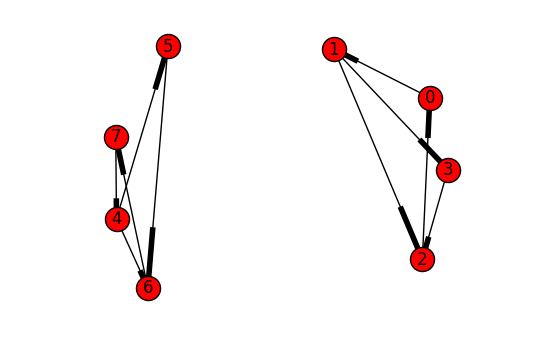

In [9]:
plt.axis('off')
nx.draw_networkx(Gc)

#### Exercise 2.13

In [10]:
random_surf(Ga,enhanced=True)

Node  0  has a score of  9.0
Node  1  has a score of  30.0
Node  2  has a score of  19.0
Node  3  has a score of  30.0
Node  4  has a score of  12.0


array([  9.,  30.,  19.,  30.,  12.])

In [11]:
random_surf(Gc, enhanced=True)

Node  0  has a score of  20.0
Node  1  has a score of  21.0
Node  2  has a score of  20.0
Node  3  has a score of  14.0
Node  4  has a score of  8.0
Node  5  has a score of  3.0
Node  6  has a score of  6.0
Node  7  has a score of  8.0


array([ 20.,  21.,  20.,  14.,   8.,   3.,   6.,   8.])

These scores make sense because the random walk is mathematically more likely to reach nodes that have a lot of 'incoming edges'.

In Ga we see that even after the enhancement, node 1 has the best score. This is because 3 other nodes have a hyperlink 'toward' it.

In Gc, we can see that the 2 subgraphs have the same shape : 5=3, 6=2, 4=1 and 7=0.

And in facts if we run the cell several times, we see that those pairs of nodes have approximately the same PageRank score (eg nodes 5 and 3 often have the lower score).

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [23]:
theta = 0.7
Gw = read_g('../data/wikipedia.graph')
N = Gw.order()
H = np.zeros((N, N))
       
for node in Gw.nodes() :
    neighbors = Gw.neighbors(node)
    odeg = len(neighbors)
    if odeg == 0:
        for index in range(N):
            H[node][index] = 1/N
    else :
        for nei in neighbors:
            H[node][nei] = 1/odeg
            
G = theta*H + (1-theta)/N

In [40]:
pi = np.zeros((N))
newPi = np.zeros((N))
newPi = newPi + 1/N
espilon = 0.00000005
count = 0
while( np.linalg.norm(newPi-pi) > espilon):
    count += 1
    print("\rNumber of iteration : ", count , end = '')
    pi = newPi
    newPi = pi @ G
    
    
print("\n")

Number of iteration :  16



In [58]:
dtype = [('node', int), ('score', float)]

values = list(zip(range(N), newPi))
a = np.array(values, dtype = dtype)
tenBest = np.sort(a, order = 'score')[0:10]
for i in range(10):
    print(tenBest[i][0])

191
244
279
306
315
332
373
378
382
384


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*